In [1]:
import numpy as np
import numpy.linalg as la

In [2]:
datasets = ['CIFAR', 'MNIST']
net_names = ['FFNN', 'ConvMed', 'ConvBig']
perturbations = [ 'Haze', 'ContrastVariation', 'Rotation']

In [3]:
import re

class Interval:
    def __init__(self, interval_str):
        m = re.match(r'\[(.*),(.*)\]', interval_str)
        self.lower, self.upper = float(m.group(1)), float(m.group(2))
    def get_abs_max(self):
        return max(abs(self.lower), abs(self.upper))
    def mono(self):
        return not (self.lower < 0 and self.upper > 0)
    def more_than_zero(self):
        return (self.lower > 0 and self.upper > 0)
    def less_than_zero(self):
        return (self.lower < 0 and self.upper < 0)

In [4]:
# experiment for MNIST varying layers from 3-9) (figure 9)

NUM_IMAGES = 100
all_data_splitting25_layers = {}
perturbations = ['Haze', 'ContrastVariation', 'Rotation']

for layers in range(3, 10):
    all_data_splitting25_layers[layers] = {}
    
    for perturbation in perturbations:  
        all_data_splitting25_layers[layers][perturbation] = []
        filename = f'results_optim_landscape/results_optim_landscape_split25/layer{layers}_{perturbation}_split25.txt'
        
        with open(filename) as f:
            content = f.readlines()
        content = [x.strip() for x in content]
        
        for header, arr in zip(content[::2], content[1::2]):
            items = header.split(',')
            interval_size = float(items[3])
            time = float(items[7])
            
            jacobians = np.array(list(map(lambda x: Interval(x).mono(), arr.split(';')[:-1]))).reshape(NUM_IMAGES, 10*25)           
            all_data_splitting25_layers[layers][perturbation].append((interval_size, time, jacobians))   

In [5]:
from statistics import median

toplot = {}

for layers in range(3, 10):
    toplot[layers] = {}
    
    for perturbation in perturbations:
        best_sizes = []
        
        for img_i in range(NUM_IMAGES):
            category = img_i // int(NUM_IMAGES / 10)
            
            found_size = False
            for (interval_size, time, jacobians) in all_data_splitting25_layers[layers][perturbation]:
                jacobi = jacobians[img_i]
                
                mono = [0 for _ in range(10)]
                jacobi_reshaped = jacobi.reshape(25, 10)
                for row in jacobi_reshaped:
                    for i, elem in enumerate(row):
                        if elem:
                            mono[i] += 1
                
                if mono[category] > 0:
                    if not found_size:
                        best_sizes.append(interval_size/25 * mono[category])
                        found_size = True
                    else:
                        if interval_size/25 * mono[category] > best_sizes[-1]:
                            best_sizes[-1] = interval_size/25 * mono[category]
            
            if not found_size:
                best_sizes.append(0)
        
        assert(len(best_sizes) == NUM_IMAGES)
        toplot[layers][perturbation] = sum(best_sizes) / NUM_IMAGES

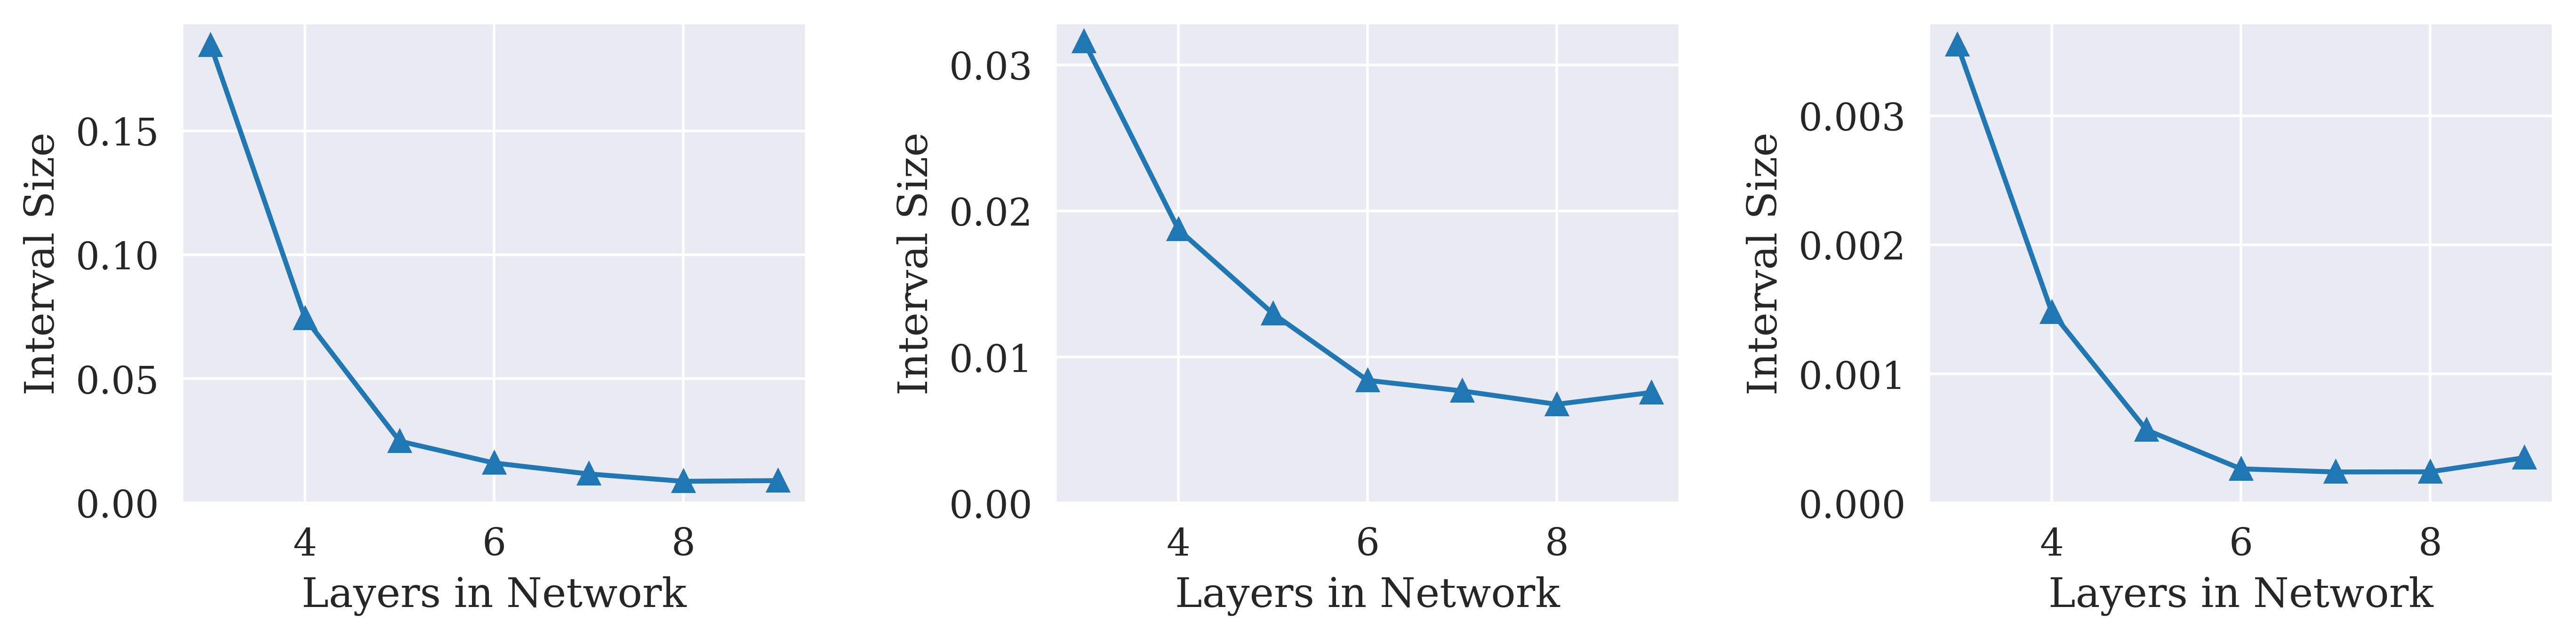

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

params = {'axes.labelsize': 12.5,
          'axes.titlesize': 14.0,
          'xtick.labelsize': 11.5,
          'ytick.labelsize': 11.5}
plt.rcParams.update(params)

sns.set_style("darkgrid", {'font.family':'serif', 'font.serif':'Times New Roman'})
fig, axs = plt.subplots(1, 3, figsize=(13, 2.7), dpi=500)
plt.subplots_adjust(wspace=0.4)

hazes = []
contrasts = []
rotations = []
for l in range(3, 10):
    hazes.append(toplot[l]['Haze'])
    contrasts.append(toplot[l]['ContrastVariation'])
    rotations.append(toplot[l]['Rotation'])

axs[0].set_xlabel('Layers in Network')
axs[0].set_ylabel('Interval Size')
axs[0].plot(range(3, 10), hazes, '-^')
axs[0].yaxis.set_major_locator(plt.MaxNLocator(4))

plt.locator_params(axis='y', nbins=4)
axs[1].set_xlabel('Layers in Network')
axs[1].set_ylabel('Interval Size')
axs[1].plot(range(3, 10), contrasts, '-^')
axs[1].set_yticks([0, 0.015, 0.032])
axs[1].yaxis.set_major_locator(plt.MaxNLocator(4))

plt.locator_params(axis='y', nbins=4)
axs[2].set_xlabel('Layers in Network')
axs[2].set_ylabel('Interval Size')
axs[2].plot(range(3, 10), rotations, '-^')
axs[2].set_yticks([0, 0.001, 0.002, 0.003])

plt.savefig('optimization_mnist_varylayers.png', bbox_inches='tight')

In [7]:
# experiment for ConvBig, ConvMed, FFNN networks (table 3)

from operator import itemgetter

NUM_IMAGES = 100

all_data_splitting25 = {}

for dataset in datasets:
    all_data_splitting25[dataset] = {}
    for net in net_names:
        all_data_splitting25[dataset][net] = {}
        for perturbation in perturbations:  
            data = []
            filename = f'results/results_split25/{net}_{dataset}_{perturbation}_split25.txt'
            with open(filename) as f:
                content = f.readlines()
            content = [x.strip() for x in content] 
            
            for header, arr in zip(content[::2], content[1::2]):
                items = header.split(',')
                interval_size = float(items[4])
                time = float(items[7])
                
                jacobians = np.array(list(map(lambda x: Interval(x).mono(), arr.split(';')[:-1]))).reshape(NUM_IMAGES, 10*25)
                data.append((interval_size, time, jacobians))
                
            filename = f'results/results_split25_add/{net}_{dataset}_{perturbation}_split25.txt'
            with open(filename) as f:
                content = f.readlines()
            content = [x.strip() for x in content]
            
            for header, arr in zip(content[::2], content[1::2]):
                items = header.split(',')
                interval_size = float(items[4])
                time = float(items[7])
                
                jacobians = np.array(list(map(lambda x: Interval(x).mono(), arr.split(';')[:-1]))).reshape(NUM_IMAGES, 10*25)
                data.append((interval_size, time, jacobians))
            
            data.sort(key=itemgetter(0))
            all_data_splitting25[dataset][net][perturbation] = data

In [8]:
tocompute = {}

for dataset in datasets:
    tocompute[dataset] = {}
    
    for net in net_names:
        tocompute[dataset][net] = {}
        
        for perturbation in perturbations:
            best_sizes = []
        
            for img_i in range(NUM_IMAGES):
                category = img_i // 10
                
                found_size = False
                for (interval_size, time, jacobians) in all_data_splitting25[dataset][net][perturbation]:
                    jacobi = jacobians[img_i]

                    mono = [0 for _ in range(10)]
                    jacobi_reshaped = jacobi.reshape(25, 10)
                    for row in jacobi_reshaped:
                        for i, elem in enumerate(row):
                            if elem:
                                mono[i] += 1
                    
                    if mono[category] > 0:
                        if not found_size:
                            best_sizes.append(interval_size/25 * mono[category])
                            found_size = True
                        else:
                            if interval_size/25 * mono[category] > best_sizes[-1]:
                                best_sizes[-1] = interval_size/25 * mono[category]

                if not found_size:
                    best_sizes.append(0)

            assert(len(best_sizes) == NUM_IMAGES)
            tocompute[dataset][net][perturbation] = sum(best_sizes) / NUM_IMAGES

In [9]:
tocompute

{'CIFAR': {'FFNN': {'Haze': 6.215906028800003e-05,
   'ContrastVariation': 7.534250688000005e-05,
   'Rotation': 3.644060492000001e-07},
  'ConvMed': {'Haze': 0.004224238947199999,
   'ContrastVariation': 0.0039619385344,
   'Rotation': 4.4042850136e-05},
  'ConvBig': {'Haze': 4.4018263999999974e-06,
   'ContrastVariation': 4.6663703807999985e-06,
   'Rotation': 2.2980750400000002e-08}},
 'MNIST': {'FFNN': {'Haze': 0.0009683778220800002,
   'ContrastVariation': 0.0020065929939200025,
   'Rotation': 6.676788465599998e-05},
  'ConvMed': {'Haze': 0.0077907321888000015,
   'ContrastVariation': 0.017965955008000002,
   'Rotation': 0.0013093106348},
  'ConvBig': {'Haze': 0.00013369424150399994,
   'ContrastVariation': 0.0007566310400000001,
   'Rotation': 1.8565960128e-05}}}